In [1]:
import os
import datetime
import string
import math
import random
import tensorflow as tf
import sklearn.model_selection
import matplotlib.pyplot as plt
import keras_ocr

2024-10-02 00:04:25.951092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 00:04:26.130697: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
tf.__version__

'2.10.0'

In [2]:
# Установка директории с данными
data_dir = 'text'

# Алфавит якутского языка
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

# Пути к файлам данных
wordlist_file = os.path.join(data_dir, 'sah.wordlist')
fonts_list_file = os.path.join(data_dir, 'okfonts_test.txt')
fonts_dir = os.path.join(data_dir, 'fonts')

In [3]:
# Загрузка списка слов из файла wordlist_file
with open(wordlist_file, 'r', encoding='utf-8') as f:
    word_list = [line.strip() for line in f if line.strip()]

# Создание генератора текста
def get_text_generator(words):
    while True:
        for word in words:
            yield word

text_generator = get_text_generator(word_list)
print('Первый сгенерированный текст:', next(text_generator))

Первый сгенерированный текст: аҕа


In [4]:
# Загрузка списка директорий шрифтов из файла fonts_list_file
with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]

font_paths = []

# Проходим по каждой директории и собираем файлы шрифтов
for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    # Рекурсивно ищем файлы шрифтов в директории font_dir_path
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

# Вывод количества найденных шрифтов
print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [5]:
# Разделение данных на тренировочные, валидационные и тестовые наборы
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

# Разделение списка слов
train_words, val_words, test_words = get_train_val_test_split(word_list)

# Разделение шрифтов
train_fonts, val_fonts, test_fonts = get_train_val_test_split(font_paths)

In [6]:
# backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

# Создание генераторов изображений без фонов
font_splits = [train_fonts, val_fonts, test_fonts]

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            char: current_fonts for char in recognizer_alphabet
        },
        backgrounds=None,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts in font_splits
]

Первое сгенерированное валидационное изображение содержит текст: аҕ
алаллар


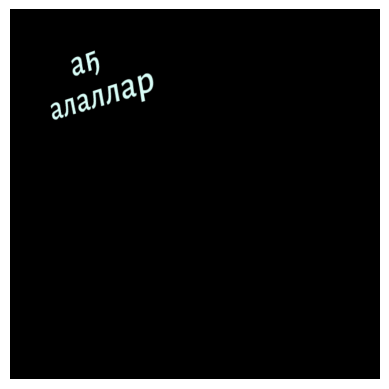

In [7]:
# Проверим первое сгенерированное изображение без фона
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('Первое сгенерированное валидационное изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
# Создание распознавателя
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights=None  # Обучение с нуля
)
recognizer.compile()

2024-10-02 00:04:28.674160: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-02 00:04:28.674205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: e24d1dc5ca34
2024-10-02 00:04:28.674213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: e24d1dc5ca34
2024-10-02 00:04:28.674429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-10-02 00:04:28.674451: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.12
2024-10-02 00:04:28.675074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in

In [9]:
# Подготовка данных для обучения распознавателя
max_length = 15

recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=0
    ) for image_generator in image_generators
]

Это изображение содержит текст: аҕа


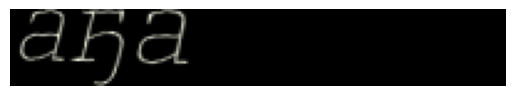

In [10]:
# Посмотрим, как выглядит первое сгенерированное изображение для распознавателя валидационной выборки
image, text = next(recognition_image_generators[1])
print('Это изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [11]:
# Создание генераторов батчей для распознавателя
recognition_batch_size = 2
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')

recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=recognition_batch_size,
        lowercase=True
    ) for image_generator in recognition_image_generators
]

In [12]:
train_steps = 1000
val_steps = 200

# Обучение распознавателя
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=100,
    steps_per_epoch=train_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=val_steps,
    workers=0,
    batch_size=recognition_batch_size
)

Epoch 1/100
1000/1000 [==============================] - 404s 398ms/step - loss: 12.8590 - val_loss: 15.7041
Epoch 2/100
1000/1000 [==============================] - 394s 394ms/step - loss: 12.0785 - val_loss: 12.4505
Epoch 3/100
 958/1000 [===========================>..] - ETA: 15s - loss: 13.2011

2024-10-02 00:23:38.771471: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/di

UnknownError: Graph execution error:

RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in get_batch_generator
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/recognition.py", line 433, in <listcomp>
    batch = [sample for sample, _ in zip(image_generator, range(batch_size))]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 293, in convert_image_generator_to_recognizer_input
    image, lines = next(image_generator)

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_15078]

In [ ]:
# Генерируем изображение из тестового генератора
test_image_generator = recognition_image_generators[2]
# Получаем одно изображение и соответствующий текст
test_image, actual_text = next(test_image_generator)

# Используем распознаватель для предсказания текста на изображении
predicted_text = recognizer.recognize(test_image)

print(f'Predicted: {predicted_text[0]}, Actual: {actual_text}')
plt.imshow(test_image)
plt.axis('off')
plt.show()